











































































































<h1><big><center>Object recognition and computer vision 2023/2024</center></big></h1>

<h2><big><center> Assignment 1: Instance-level recognition</center></big></h2>

<h5><big><center>Adapted from practicals from <a href="http://www.robots.ox.ac.uk/~vgg/practicals/overview/index.html">Andrea Vedaldi and Andrew Zisserman</a>
 <br>by <a href="https://www.di.ens.fr/~varol/">Gul Varol</a>, and <a href="https://www.di.ens.fr/~iroccosp/">Ignacio Rocco</a>,
 <br>and from practicals from <a href="https://cs.nyu.edu/~fouhey/teaching/EECS442_W23">David Fouhey</a> by <a href="https://16lemoing.github.io">Guillaume Le Moing</a> </center></big></h5>

</br>
<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis17orig/assignment1/images/image12.png"/></p>
<p align="center"></p>

**STUDENT**:  Imane SI SALAH

**EMAIL**:  imane.si_salah@ens-paris-saclay.fr

# Guidelines

The purpose of this assignment is that you get hands-on experience with the topics covered in class, which will help you understand these topics better. Therefore, **it is imperative that you do this assignment yourself. No code sharing will be tolerated.**

Once you have completed the assignment, you will submit the `ipynb` file containing **both** code and results. For this, make sure to **run your notebook completely before submitting**.

The `ipynb` must be named using the following format: **A1_LASTNAME_Firstname.ipynb**, and submitted in the **Google Classroom page**.

# Goal
The goal of instance-level recognition is to match (recognize) a specific object or scene.  Examples include recognizing a specific building, such as Notre Dame, or a specific painting, such as `Starry Night’ by Van Gogh. The object is recognized despite changes in scale, camera viewpoint, illumination conditions and partial occlusion. An important application is image retrieval - starting from an image of an object of interest (the query), search  through an image dataset to obtain (or retrieve) those images that contain the target object.

The goal of this assignment is to experiment and get basic practical experience with the methods that enable specific object recognition. It includes: (i) using SIFT features to obtain sparse matches between two images; (ii) using similarity co-variant detectors to cover changes in viewpoint; (iii) vector quantizing the SIFT descriptors into visual words to enable large scale retrieval; and (iv) constructing and using an image retrieval system to identify objects.

# Setup environment

We recommend using Google Colab (no GPU required).

## Download and install CyVLFeat

The new version of Cython in Colab is not compatible with the cyvlfeat libray so we need to downgrade it.

In [1]:
!pip install Cython==3.0.0a9

Now we can install cyvlfeat.

In [2]:
!wget -N http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py
%run install_cyvlfeat.py

--2023-10-22 17:21:28--  http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py [following]
--2023-10-22 17:21:28--  https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/install_cyvlfeat.py
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘install_cyvlfeat.py’ not modified on server. Omitting download.

installing cython... done!
building cyvlfeat... done!
installing cyvlfeat... done! NOTE: to uninstall run: cat cyvlfeat_files.txt | xargs rm -rf
copying vlfeat dynamic libary to a reachable location... done!
Installation of cyvlfeat is finished


## Imports

In [3]:
# nice plot display
# uncomment if you are using jupyter lab, requires ipympl: https://github.com/matplotlib/jupyter-matplotlib
#%matplotlib widget
# uncomment if you are using jupyter notebook
# %matplotlib notebook

import cyvlfeat
import numpy as np
from skimage.io import imread
from skimage.transform import resize, rotate
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from cyvlfeat.plot import plotframes
from scipy.io import loadmat
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import math

# change some default matplotlib parameters
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.dpi'] = 120

# ignore warnings
warnings.filterwarnings('ignore')

## Download and uncompress data

In [4]:
print('downloading assignment images...')
!wget -c http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/A1_images.tar.gz
print('done!')
print('uncompressing...')
!tar -xzf A1_images.tar.gz
print('done!')

downloading assignment images...
--2023-10-22 17:21:38--  http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/A1_images.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/A1_images.tar.gz [following]
--2023-10-22 17:21:38--  https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/A1_images.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘A1_images.tar.gz’

A1_images.tar.gz        [     <=>            ]   7.52M  7.72MB/s    in 1.0s    

2023-10-22 17:21:39 (7.72 MB/s) - ‘A1_images.tar.gz’ saved [7881637]

done!
uncompressing...
done!


# Part 1: Sparse features for matching specific objects in images

## Feature point detection

The SIFT feature has both a *detector* and a *descriptor*. The *detector* used in SIFT corresponds to the "difference of Gaussians" (DoG) detector, which is an approximation of the "Laplacian of Gaussian"  (LoG) detector.

We will start by computing and visualizing the SIFT feature detections (usually called frames) for two images of the same object (a building facade). Load an image, rotate and scale it, and then display the original and transformed pair:

2079744
3142596


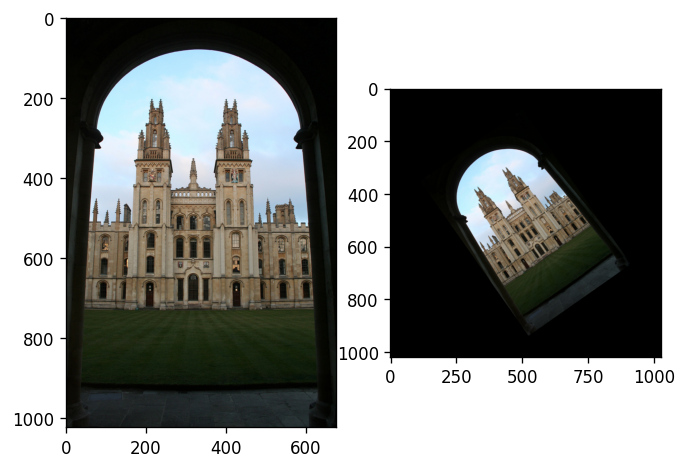

In [5]:
# Load an image
im1 = imread('data/oxbuild_lite/all_souls_000002.jpg')

# Let the second image be a rotated and scaled version of the first
im1prime = rotate(np.pad(im1, ((0,0), (200,200),(0,0)), 'constant'), 35, 'bilinear')
h, w, _ = im1prime.shape
im1prime = resize(im1prime, (int(0.7 * h), int(0.7 * w)))
im1prime = (255 * im1prime).astype(np.uint8)
print(im1.size)
print(im1prime.size)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1)
ax2.imshow(im1prime)
plt.show()

A SIFT frame is a circle with an orientation and is specified by four parameters: the center $x$, $y$, the scale $s$, and the rotation $\theta$ (in radians), resulting in a vector of four parameters $(x, y, s, \theta)$.

Now compute and visualise the SIFT feature detections (frames):

In [6]:
def rgb2gray(rgb):
    return np.float32(np.dot(rgb[..., :3], [0.299, 0.587, 0.114]) / 255.0)

(952, 4)
(654, 128)


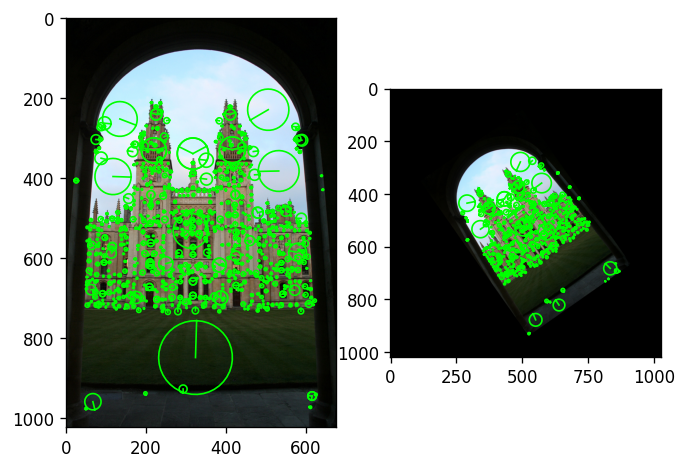

In [7]:
# Compute SIFT features for each

[frames1, descrs1] = cyvlfeat.sift.sift(rgb2gray(im1), peak_thresh=0.01)

[frames1prime, descrs1prime] = cyvlfeat.sift.sift(rgb2gray(im1prime), peak_thresh=0.01)

print(frames1.shape)
print(descrs1prime.shape)

f, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.imshow(im1)
plotframes(frames1, linewidth=1)

plt.sca(ax2)
plt.imshow(im1prime)
plotframes(frames1prime, linewidth=1)

plt.show()

Examine the second image and its rotated and scaled version and convince yourself that the detections overlap the same scene regions (even though the circles' positions have moved in the image and their radius' have changed).
This demonstrates that the detection process (is co-variant or equi-variant) with translations, rotations and isotropic scalings. This class of transformations is known as a similarity or equiform.

### :: TASK 1.1 ::

Now repeat the exercise with a pair of natural images.

Start by loading the second one: `data/oxbuild_lite/all_souls_000015.jpg`

Plot the images and feature frames. Again you should see that many of the detections overlap the same scene region. Note that, while repeatability occurs for the pair of natural views, it is much better for the synthetically rotated pair.

(1123, 4)
(1123, 128)


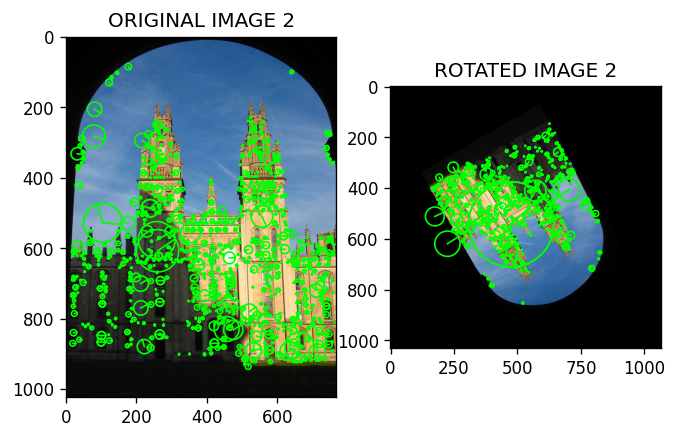

In [8]:
##########################

im2= imread('data/oxbuild_lite/all_souls_000015.jpg')
#get the sift featues
[frames2, descrs2] = cyvlfeat.sift.sift(rgb2gray(im2), peak_thresh=0.01)
print(frames2.shape)
print(descrs2.shape)

## get the rotated image
im2prime = rotate(np.pad(im2, ((0,0), (200,200),(0,0)), 'constant'), 210, 'bilinear')
h, w, _ = im2prime.shape
im2prime = resize(im2prime, (int(0.7 * h), int(0.7 * w)))
im2prime = (255 * im2prime).astype(np.uint8)
[frames2prime, descrs2prime] = cyvlfeat.sift.sift(rgb2gray(im2prime), peak_thresh=0.01)

figure, axes= plt.subplots(1,2)
plt.sca(axes[0])
plt.imshow(im2)
plotframes(frames2, linewidth=1)
plt.title("ORIGINAL IMAGE 2")
plt.sca(axes[1])
plt.imshow(im2prime)
plotframes(frames2prime, linewidth=1)
plt.title("ROTATED IMAGE 2")

plt.show()


##########################
#### noticz that  the shadowed region s not wzll detected

The number of detected features can be controlled by changing the peakThreshold option. A larger value will select features that correspond to higher contrast structures in the image.

### :: TASK 1.2 ::

***For the same image, produce 3 sub-figures with different values of peakThreshold. Comment.***

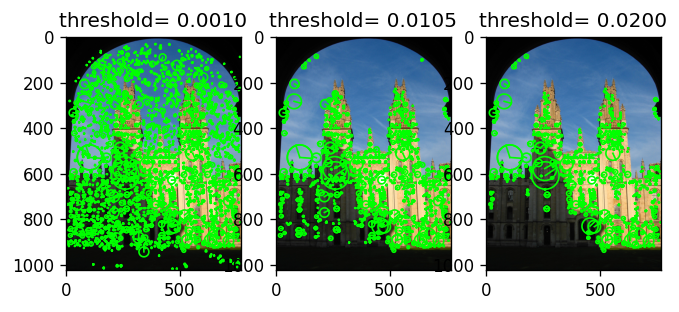

In [9]:
##########################
d=0.01
peak_thresh= np.linspace(0.001, 0.01+d, 3)

fig, axs= plt.subplots(1,3)
for i, thresh in enumerate(peak_thresh):
  [frames, descrs] = cyvlfeat.sift.sift(rgb2gray(im2), peak_thresh=thresh)
  plt.sca(axs[i])
  plt.imshow(im2)
  plotframes(frames, linewidth=1)
  plt.title("threshold= {:.4f}".format(thresh))

plt.show()
##########################

######################

We see that as the threshold is increased, the shadowed region contains less descriptors, as It has less contrast overall, so most of its  features lie below the threshold value

######################

## Feature point description and matching

### Introduction to feature descriptors

The parameters $(t_x, t_y, s, \theta)$ of the detected *frames*,  can be used to extract a **scaled and oriented RGB patch** around $(t_x,t_y)$, used to *describe* the feature point.

The simplest possible descriptor would be to (i) resize these patches to a common size (eg. 30x30) and (ii) flatten to a vector. However, in practice we use more sophisticated descriptors such as SIFT, that is based on histograms of gradient orientations.

### :: TASK 1.3 ::


***What is the interest of using SIFT descriptors over these flattened RGB patches?***

######################

   LESS MEMORY, ORIENTATION AND VARIATION INVARIENT

######################


### Descriptor matching
SIFT descriptors are 128-dimensional vectors, and can be directly *matched* to find correspondences between images. We will start with the simplest matching scheme (first nearest neighbour of descriptors in terms of Euclidean distance) and then add more sophisticated methods to eliminate any mismatches.

### :: TASK 1.4 ::


For each descriptor in im1, assign a matching descriptor in im2 by picking its first nearest neighbour.

Populate the second column of the matches vector.

In [10]:
def matching(frames1, frames2, descrs1, descrs2):

  # number of detections in image 1
  N_frames1 = frames1.shape[0]
  N_frames2= frames2.shape[0]
  # allocate matrix for storing the matches
  matches = np.zeros((N_frames1, 2), dtype=np.int)
  # the first column of the matrix are the indices on image 1: 0,1,2,....,N_frames1-1
  matches[:, 0] = range(N_frames1)

  # write code to find the matches in image 2 of each feature in image 1
  # populate the second column of the matches vector

  ##########################
  # we find the matches usign the first nearest neighbor which is the index of the min distance

  for i in range(N_frames1):
        distances = [euclideanD(descrs1[i], descrs2[j]) for j in range(N_frames2)]
        matches[i, 1] = np.argmin(distances)
    ##########################

  return matches

def euclideanD(a,b):
  return np.sqrt(np.sum((a-b)**2))

Compute the matches.

In [11]:
matches = matching(frames1, frames2, descrs1, descrs2)

Plot the matches.

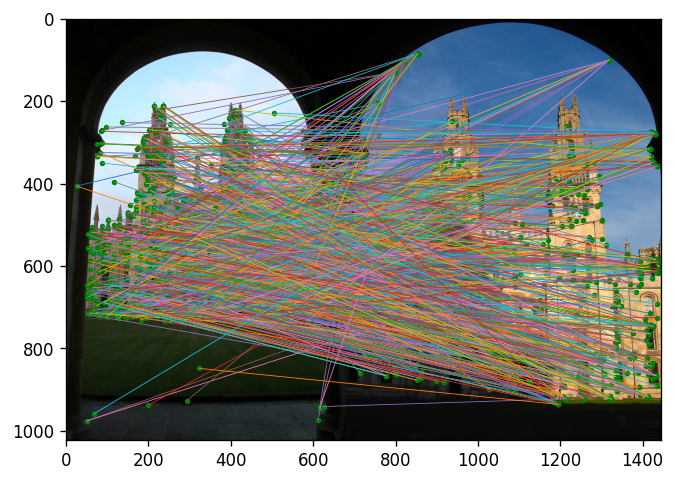

In [12]:
def plot_matches(im1, im2, frames1, frames2, matches):
  plt.figure()
  plt.imshow(np.concatenate((im1,im2),axis=1))
  for idx in range(matches.shape[0]):
      i=matches[idx,0]
      j=matches[idx,1]
      # plot dots at feature positions
      plt.gca().scatter([frames1[i,0],im1.shape[1]+frames2[j,0]], [frames1[i,1],frames2[j,1]], s=5, c='green')
      # plot lines
      plt.plot([frames1[i,0],im1.shape[1]+frames2[j,0]],[frames1[i,1],frames2[j,1]],linewidth=0.5)
  plt.show()

plot_matches(im1, im2, frames1, frames2, matches)

## Improving SIFT matching (i) using Lowe’s second nearest neighbour test


Lowe introduced a second nearest neighbour (2nd NN) test to identify, and hence remove, ambiguous matches. The idea is to identify distinctive matches by a threshold on the ratio of first to second NN distances.

The ratio is:  $$NN_{ratio} = \frac{1^{st}\text{NN distance}}{2^{nd}\text{NN distance}}.$$



### :: TASK 1.5 ::

***For each descriptor in im1, compute the ratio between the first and second nearest neighbour distances.***

***Populate the ratio vector.***


In [13]:
# allocate matrix for storing the matches
ratio = np.zeros((frames1.shape[0], 1))

# write code to find the 1st/2nd NN ratio for each descriptor in im1
# populate the ratio vector

##########################
for i in range(frames1.shape[0]):
        distances = [euclideanD(descrs1[i], descrs2[j]) for j in range(frames2.shape[0])]
        NN_1= np.argmin(distances)
        distances_removed = np.delete(distances, NN_1)  # we remove the first nearest neighbor from the distances list
        NN_2 = np.argmin(distances_removed)
        ratio[i] = distances[NN_1] / distances_removed[NN_2]
##########################

In [14]:
print(ratio.shape)

(952, 1)


The ratio vector will be now used to retain only the matches that are above a given threshold.

A value of $NN_{threshold} = 0.8$ is often a good compromise between losing too many matches and rejecting mismatches.

In [15]:
NN_threshold = 0.8
matches = matching(frames1, frames2, descrs1, descrs2)
filtered_indices = np.flatnonzero(ratio < NN_threshold)
filtered_matches = matches[filtered_indices, :]

Plot the filtered matches.

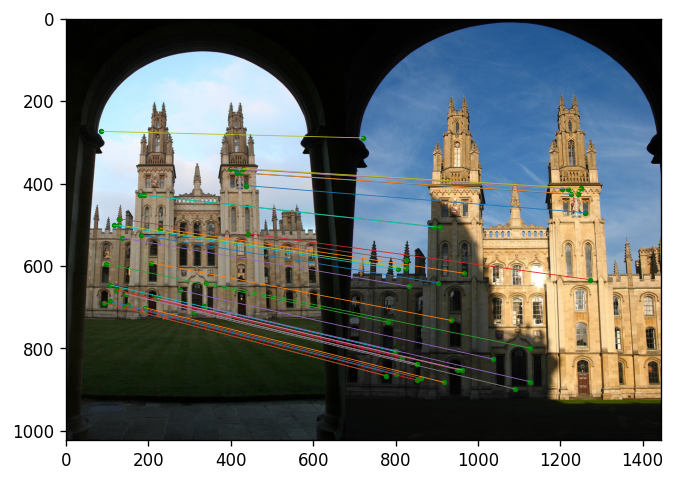

In [16]:
plot_matches(im1, im2, frames1, frames2, filtered_matches)

## Improving SIFT matching (ii) by geometric verification

In addition to the 2nd NN test, we can also require consistency between the matches and a geometric transformation between the images. For the moment we will look for matches that are consistent with a similarity transformation:

$$\begin{bmatrix} x_2 \\ y_2 \end{bmatrix} =
sR(\theta) \begin{bmatrix} x_1 \\ y_1 \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix} $$

which consists of a rotation by $\theta$, an isotropic scaling (i.e. same in all directions) by s, and a translation by a vector $(t_x, t_y)$. This transformation is specified by four parameters $(s,\theta,t_x,t_y)$ and can be computed from a single correspondence between SIFT detections in each image.

### :: TASK 1.6 ::

Given a detected feature with parameters $(x_1, y_1, s_1, \theta_1)$ in image $1$ matching a feature $(x_2, y_2, s_2, \theta_2)$ in image $2$, work out how to find out the parameters $(t_x,t_y,s,\theta)$ of the transformation mapping points from image $1$ to image $2$.




$$\theta= \theta_2 - \theta_1$$
$$s=s_2/ s_1$$
$$\begin{bmatrix} t_x \\ t_y \end{bmatrix} =\begin{bmatrix} x_2  \\ y_2  \end{bmatrix} - sR(\theta) \begin{bmatrix} x_1 \\ y_1 \end{bmatrix}$$


The matches consistent with a similarity can then be found using the RANSAC algorithm, described by the following steps:

For each tentative correspondence in turn:

* compute the similarity transformation;
* map all the SIFT detections in one image to the other using this transformation;
* accept matches that are within a threshold distance to the mapped detection (inliers);
* count the number of accepted matches;
* optionally, fit a more accurate affine transformation or homography to the accepted matches and test re-validate the matches.

Finally, choose the transformation with the highest count of inliers

After this algorithm the inliers are consistent with the transformation and are retained, and most mismatches should now be removed.

### :: TASK 1.7 ::

In [49]:
def ransac(frames1,frames2,matches,N_iters=400,dist_thresh=25):#18
    # initialize
    max_inliers = 0
    tnf = None
    # run random sampling
    for it in range(N_iters):
        # pick a random sample
        i = np.random.randint(0, frames1.shape[0])
        x_1, y_1, s_1, theta_1 = frames1[i, :]
        j = matches[i, 1]
        x_2, y_2, s_2, theta_2 = frames2[j, :]

        # estimate transformation

        ##################################
        theta = theta_2 - theta_1
        s = s_2/s_1
        t_x = x_2 - s* (x_1 * np.cos(theta) - y_1 * np.sin(theta))
        t_y =y_2 - s* (x_1 * np.sin(theta) + y_1 * np.cos(theta))
        ##################################

        # evaluate estimated transformation
        X_1 = frames1[:, 0]
        Y_1 = frames1[:, 1]
        X_2 = frames2[matches[:, 1], 0]
        Y_2 = frames2[matches[:, 1], 1]

        X_1_prime = s * (X_1 * np.cos(theta) - Y_1 * np.sin(theta)) + t_x
        Y_1_prime = s * (X_1 * np.sin(theta) + Y_1 * np.cos(theta)) + t_y

        dist = np.sqrt((X_1_prime - X_2) ** 2 + (Y_1_prime - Y_2) ** 2)

        inliers_indices = np.flatnonzero(dist < dist_thresh)
        num_of_inliers = len(inliers_indices)

        # keep if best
        if num_of_inliers > max_inliers:
            max_inliers = num_of_inliers
            best_inliers_indices = inliers_indices
            tnf = [t_x, t_y, s, theta]

    return (tnf, best_inliers_indices)

In [18]:
[frames1, descrs1] = cyvlfeat.sift.sift(rgb2gray(im1), peak_thresh=0.01)
[frames2, descrs2] = cyvlfeat.sift.sift(rgb2gray(im2), peak_thresh=0.01)
print(frames1.shape)
print(frames2.shape)


(952, 4)
(1123, 4)


In [19]:
matches = matching(frames1, frames2, descrs1, descrs2)

In [20]:
tnf, inliers_indices = ransac(frames1, frames2, matches)
filtered_matches = matches[inliers_indices, :]

Plot matches filtered with RANSAC.

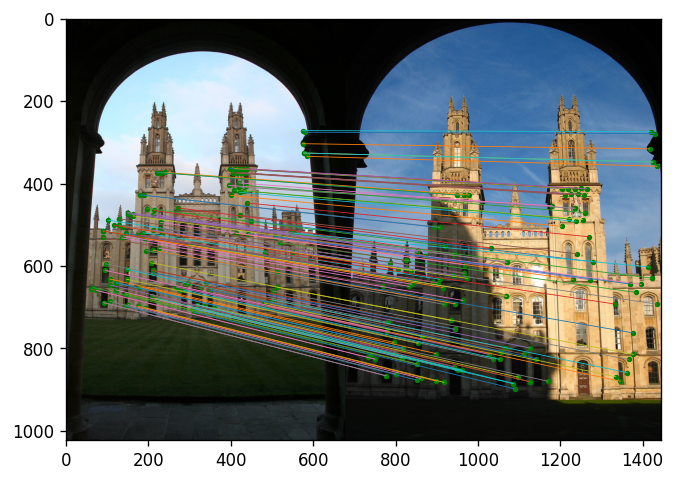

In [21]:
plot_matches(im1, im2, frames1, frames2, filtered_matches)

## Augmented reality via template matching

<center><img height=200px src="http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/augmented_reality.png"/></p>
<p align="center"></p></center>

Now that we are able to draw consistent matches between pairs of images, we can use them to start replacing things in our reality. Imagine that we have a template
image and this template appears in the world but viewed at a different angle. We can fit a homography mapping between the template and the scene. Once we know the homography, we can use any new image to replace the template in the scene.

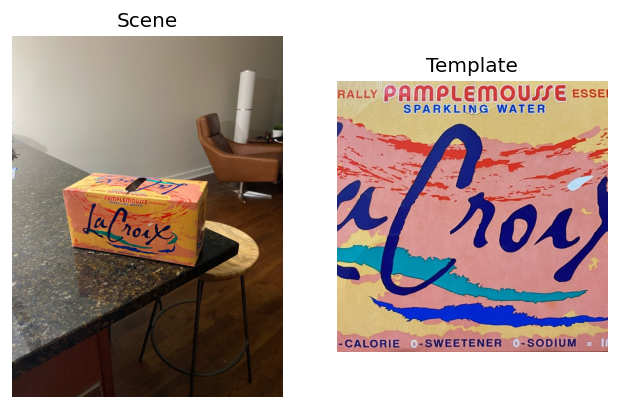

In [22]:
# Load the template and the scene
template = imread('data/augmented_reality/template.png')
scene = imread('data/augmented_reality/scene.png')
h, w, _ = scene.shape
factor = h / template.shape[0]
templatexl = (resize(template, (h, h)) * 255).astype(np.uint8)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(scene)
ax2.imshow(template)
ax1.title.set_text('Scene')
ax2.title.set_text('Template')
ax1.axis('off')
ax2.axis('off')
plt.show()

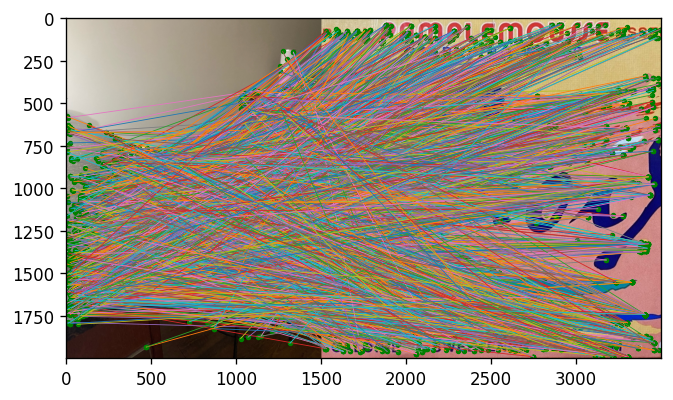

In [47]:
# Compute matches between the template and the scene

[frames_scene, descrs_scene] = cyvlfeat.sift.sift(rgb2gray(scene), peak_thresh=0.01)
[frames_template, descrs_template] = cyvlfeat.sift.sift(rgb2gray(template), peak_thresh=0.01)

matches = matching(frames_scene, frames_template, descrs_scene, descrs_template)

plot_matches(scene, templatexl, frames_scene, factor * frames_template, matches)

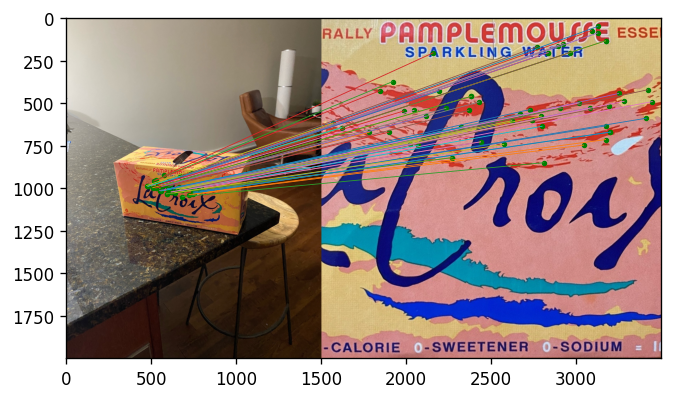

In [61]:
# Filter these matches with RANSAC

tnf, inliers_indices = ransac(frames_scene, frames_template, matches)
filtered_matches = matches[inliers_indices, :]

plot_matches(scene, templatexl, frames_scene, factor * frames_template, filtered_matches)

We wish to fit a homography using the filtered matches $i$ in $1 .. N$, that is, to find the transformation $H$ which verifies for each point $(x_1^i, y_1^i)$ from the "scene" and its correspondence $(x_2^i, y_2^i)$ in the "template":

$$ \lambda \mathbf{x_2^i} = H \mathbf{x_1^i} $$

with points expressed in homogenenous coordinates:
$$H=\begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix}, \,\,\,
\mathbf{x_1^i}=\begin{bmatrix} x_1^i \\ y_1^i \\ 1 \end{bmatrix}, \,\,\,
\mathbf{x_2^i}=\begin{bmatrix} x_2^i \\ y_2^i \\ 1 \end{bmatrix}.
$$

The scale ($\lambda$) is arbitrary. We can also write this as:
$$\mathbf{x_2^i}\times (H \mathbf{x_1^i}) = 0,$$
with $\times$ the vectorial product.

### :: TASK 1.8 ::

Given a match $(\mathbf{x_1^i}, \mathbf{x_2^i})$ and a flattened view of the matrix $H$:
$$\mathbf{\bar{h}}= \begin{bmatrix} h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h_{31} & h_{32} & h_{33} \end{bmatrix}^T,$$

find a matrix $A_i$ such that the previous equation is expressed as a system

$$A_i \mathbf{\bar{h}} = 0$$

of linearly independent equations.

$$A_i=\begin{bmatrix} -{x_1^i}& -{y_1^i} &-1 & 0 & 0 & 0 & {x_1^i}{x_2^i} & {y_1^i}{x_2^i}&  {x_2^i} \\ 0 & 0 & 0& -{x_1^i}& -{y_1^i} &-1  & {x_1^i}{y_2^i} & {y_1^i}{y_2^i}&  {y_2^i} \end{bmatrix}$$

### :: TASK 1.9 ::


***How many linearly independent equations each match gives us? How many degrees of freedom does $H$ have? Deduce the minimal number of matches to find a solution.***

######################

   Each match gives 2 linearly independent equations
   and the minimal number of matches to find a solution is 4

######################

The complete system $A \mathbf{\bar{h}} = 0$ is built by concatenating the rows of $A_i$ for every match $i$ in $1 .. N$.

A non-zero solution $\mathbf{\bar{h}}$ to this homogeneous least squares system is obtained by the singular value decomposition (SVD) of $A$. It is the singular vector corresponding to the smallest singular value. See for example [here](https://en.wikipedia.org/wiki/Singular_value_decomposition#Solving_homogeneous_linear_equations) if you are curious about the maths behind it.

### :: TASK 1.10 ::

In [25]:
def compute_homography(frames1, frames2, matches):
    x_1 = frames1[matches[:,0],0]
    y_1 = frames1[matches[:,0],1]
    x_2 = frames2[matches[:,1],0]
    y_2 = frames2[matches[:,1],1]

    #########################################

    A = np.zeros((matches.shape[0] * 2, 9))  # Initialize the matrix A with appropriate dimensions

    for i in range(matches.shape[0]):
        A[2*i, :] =[-x_1[i], -y_1[i], -1, 0, 0, 0, x_1[i]*x_2[i], y_1[i]*x_2[i], x_2[i]]
        A[2*i + 1, :] =[0, 0, 0, -x_1[i], -y_1[i], -1, x_1[i]*y_2[i], y_1[i]*y_2[i], y_2[i]]
    ##########################################
    A = np.array(A)

    # Solve for the homography using SVD
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1, :].reshape(3, 3)

    # Normalize the homography matrix
    H /= H[2, 2]

    return H

In [62]:
H = compute_homography(frames_scene, frames_template, filtered_matches)
print(H)

[[ 2.95172795e+00 -1.21462130e-01 -1.24894093e+03]
 [-2.73883348e-01  2.74444660e+00 -2.28271006e+03]
 [ 2.63802687e-04 -1.42947181e-04  1.00000000e+00]]


Now we will use the homography to replace the template in the scene by a new image.

### :: TASK 1.11 ::

Complete the function below which takes as input the homography $H$, a template and the scene and which returns an image which is the result of warping the template into the scene and overlaying it on top of the original scene using alpha compositing.

Use bilinear interpolation to determine pixel colors in the warped template given those in the original template.

<center><img height=200px src="https://gabrielgambetta.com/computer-graphics-from-scratch/images/bilinear-texture-weights.png"/></p>
<p align="center"></p></center>

More precisely, given a pixel location in the scene, let $C$ be its projection onto the template by applying the homography $H$. The resulting color of this pixel after the warping operation is a weighted sum of the color of the four nearest neighbours of $C$ in the template, with weights $(1-f_x) * (1-f_y)$, $f_x * (1-f_y)$, $(1-f_x) * f_y$ and $f_x*f_y$ for the top-left (TL), top-right (TR), bottom-left (BL), bottom-right (BR) pixels respectively.


In [27]:
def apply_homography(H, template, scene):
    height, width, _ = scene.shape

    # Initialize the warped template with the same dimensions as the scene
    w_template = np.zeros((height, width, 3), dtype=np.uint8)

    # Initialize a mask indicating the pixels in the scene where the template is visible
    mask = np.zeros((height, width, 1), dtype=np.uint8)

    # For each point in the scene
    for y in range(height):
        for x in range(width):
            # Apply the homography to find the corresponding point in the template ("C" in the illustration above)
            c = np.dot(H, [x, y, 1])
            c /= c[2]  # Normalize by the third homogeneous coordinate
            c = c[:2]  # Get cartesian coordinates from homogeneous coordinates

            # Now check if the projected point ("C") is within the bounds of the template image
            # and update the mask ("mask[y, x]") accordingly.

            # If it is inside the bounds, update the color of the warped template ("w_template[y, x]")
            # using colors from neighbouring pixels in the original "template" image (bilinear interpolation).
            # Note that "w_template" expects np.uint8 colors (discrete RGB values in 0..255)


            ###############################
            if 0 <= c[0] and c[0] +1< template.shape[1] and 0 <= c[1] and c[1] +1< template.shape[0]:
              # Update the mask ("mask[y, x]")
                mask[y, x] = 1
                fx = c[0]%1
                fy = c[1]%1
                tx = math.floor(c[0])
                ty = math.floor(c[1])

                TL = template[ty][tx]
                TR = template[ty+1][tx]
                BL = template[ty][tx+1]
                BR = template[ty+1][tx+1]

                CT = fx * TR + (1 - fx) * TL
                CB = fx * BR + (1 - fx) * BL

                w_template[y,x]=  fy * CB + (1 - fy) * CT
              ###############################



    # Alpha compositing to overlay the template on top of the scene
    result = mask * w_template + (1 - mask) * scene

    return result

Choose an image to replace the template in the scene.

In [28]:
name = "willow"  # options ["willow", "monk", "ens"]

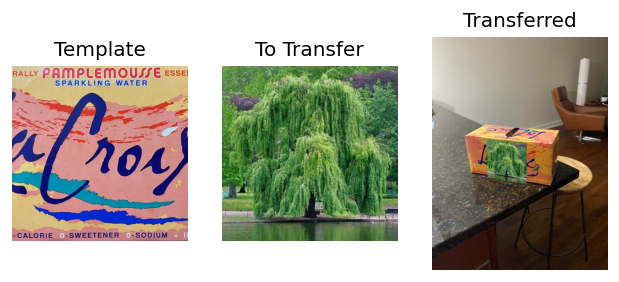

In [63]:
# Replace the template in the scene

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
replacement = imread(f'data/augmented_reality/{name}.png')
replacement = (resize(replacement, (template.shape[0], template.shape[1])) * 255).astype(np.uint8)

result = apply_homography(H, replacement, scene)

ax1.imshow(template)
ax2.imshow(replacement)
ax3.imshow(result)
ax1.title.set_text('Template')
ax2.title.set_text('To Transfer')
ax3.title.set_text('Transferred')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

# Part 2: Compact descriptors for image retrieval

In large scale retrieval the goal is to match a query image to a large database of images (for example the WWW or Wikipedia).

The quality of an image match is measured as the number of geometrically verified feature correspondences between the query and a database image. While the techniques discussed in Part 1 are sufficient to do this, in practice they require too much memory to store the SIFT descriptors for all the detections in all the database images.

In this part we will see how we can compute a *global* image descriptor from the set of SIFT descriptors using the bag-of-visual-words (BoVW) approach.

Then, we will see how these global descriptors can be used to rapidly retrieve a shortlist of candidate database images given a query image. Finally, we will see how to re-rank the shortlist of candidates using a geometric verification technique that requires only the *detector frames* and their assigned visual word indices; remember the SIFT descriptors are only used to compute the compact BoVW descriptors and then discarded.


## Download preprocessed dataset of paintings

In [30]:
print('downloading dictionary of SIFT features and precomputed BoVW descriptors for painting dataset...')
!wget -c http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat
print('done!')

downloading dictionary of SIFT features and precomputed BoVW descriptors for painting dataset...
--2023-10-22 17:24:09--  http://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat [following]
--2023-10-22 17:24:10--  https://www.di.ens.fr/willow/teaching/recvis_orig/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

done!


## Load preprocessed dataset of paintings

We will now load the preprocessed dataset of paintings. The construction of this dataset has involved several steps.


1.   SIFT features were extracted from all painting in the dataset
2.   A global vocabulary of SIFT descriptors was computed using K-means clustering. These are the visual words of our dataset.
3.  The SIFT features for each painting were assigned to the nearest word, and a compact descriptor was generated for each painting. This compact descriptor consists in the normalized histogram of words. The histogram normalization itself involves 3 different steps:
    - a) TF-IDF weighting: each word is re-weighted according to its TF-IDF value. This removes weights to words that are very common and therefore not too descriptive.
    - b) Square-rooting: each element is square-rooted
    - c) L2-normalization: The whole histogram is L2-normalized.
    




In [31]:
imdb=loadmat('paintings_imdb_SIFT_10k_preprocessed.mat')

feature_vocab = np.transpose(imdb['vocab'])
imdb_hists = imdb['index']
imdb_tfidf = imdb['idf']

imdb_url = lambda idx: imdb['images'][0][0][3][0][idx].item()

num_words = feature_vocab.shape[0]
num_paintings = imdb_hists.shape[1]

print('The vocabulary of SIFT features contains %s  visual words' % num_words)
print('The dictionary index contains %s histograms corresponding to each painting in the dataset' % num_paintings)
print('The tdf-idf vector has shape '+str(imdb_tfidf.shape))

The vocabulary of SIFT features contains 10000  visual words
The dictionary index contains 1703 histograms corresponding to each painting in the dataset
The tdf-idf vector has shape (10000, 1)


(135, 4)
(135, 128)


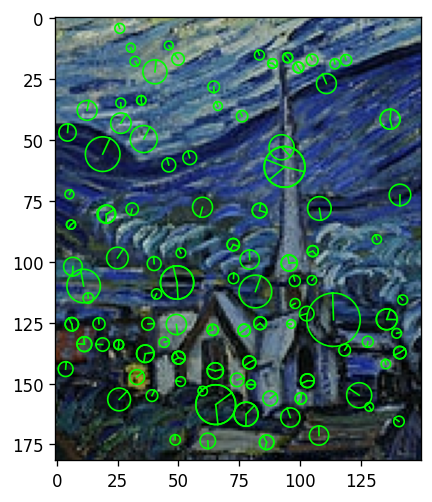

In [32]:
painting = imread('data/queries/mistery-painting1.jpg')

[frames, descrs] = cyvlfeat.sift.sift(rgb2gray(painting), peak_thresh=0.01)
print(frames.shape)
print(descrs.shape)
plt.figure()
plt.imshow(painting)
plotframes(frames,linewidth=1)

### :: TASK 2.1 ::

Construct a KDTree of the vocabulary for fast NN search. Then use the KDTree to find the closest word in the vocabulary to each descriptor of the query image.


In [35]:
from sklearn.neighbors import KDTree

##########################
tree = KDTree(np.transpose(imdb['vocab']),leaf_size=40)
distances, index = tree.query(descrs, k=1)
print(distances.shape)

##########################

(135, 1)


### :: TASK 2.2 ::
Compute the compact BoVW descriptor of the query image.

In [44]:
query_hist = np.zeros((num_words, 1))

##########################
for i in index:
    query_hist[i] += 1
##########################


In [37]:
print(np.sum(query_hist[:,0]))

135.0


In [38]:
# process histogram
query_hist = query_hist*imdb_tfidf
query_hist = np.sqrt(query_hist)
query_hist = query_hist/np.linalg.norm(query_hist)


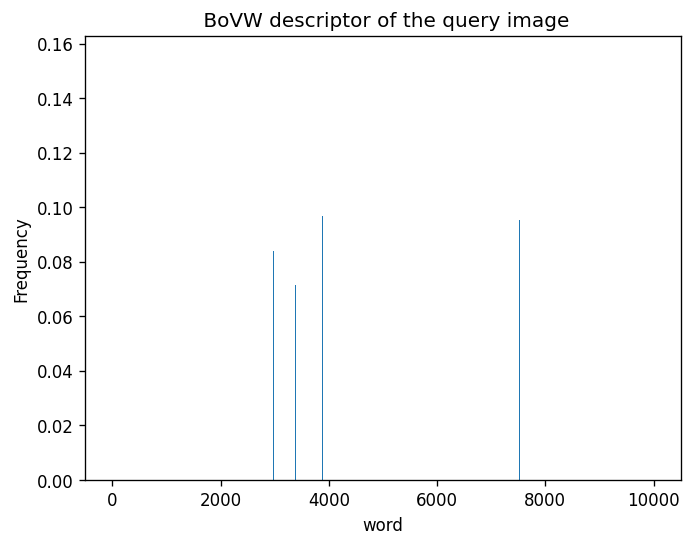

In [39]:
plt.figure()
plt.bar(range(num_words), query_hist[:,0])
plt.xlabel('word')
plt.ylabel('Frequency')
plt.title(' BoVW descriptor of the query image')
plt.show()

### :: TASK 2.3 ::

Compute the matching score with each image from the database.



In [40]:
scores = np.zeros((1, num_paintings))

##########################
#compute the cosine similarity for each histogram
for i in range(num_paintings):
    hist = imdb_hists[:, i]
    score = cosine_similarity(hist.reshape(1, -1), query_hist.reshape(1, -1))[0, 0]
    scores[0, i] = score
##########################

In [41]:
# sort in descending order
scores_sorted_idx = np.argsort(-scores)
scores_sorted = scores.ravel()[scores_sorted_idx]

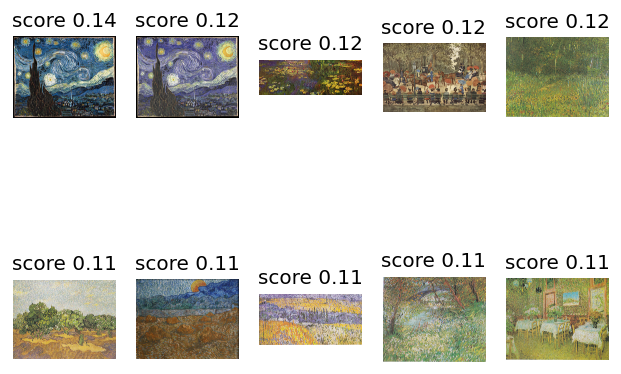

In [42]:
# plot top matches
N = 10
top_N_idx = scores_sorted_idx.ravel()[:N]

plt.figure()
for i in range(N):
    # download images
    url = imdb_url(top_N_idx[i])
    img = imread(url, pilmode='RGB')
    # choose subplot
    plt.subplot(int(np.ceil(N/5)),5,i+1)
    # plot
    plt.imshow(img)
    plt.axis('off')
    plt.title('score %1.2f' % scores_sorted.ravel()[i])

### :: TASK 2.4 (optional) ::

Using the frame information and the assigned words of each descriptor, extract matching frames between the query and the shortlist of database images and perform geometric verification using a similarity transformation with no rotation.

Compute the inlier scores and use it to re-rank this short list. Analyze the gap in the inlier count of the correct match and the incorrect ones.

In [43]:
imdb_frames = lambda idx: imdb['images'][0][0][5][0][idx] # usage: imdb_frames(idx)
imdb_words = lambda idx: imdb['images'][0][0][6][0][idx] # usage: imdb_words(idx)

##########################
#                        #
#  WRITE YOUR CODE HERE  #
#                        #
##########################

## AUTHORSHIP STATEMENT

I declare that the preceding work was the sole result of my own effort and that I have not used any code or results from third-parties.

Imane SI SALAH